# **MNIST-1D**: Finding & analyzing lottery tickets
Sam Greydanus

In this notebook we'll show how to find a sparsely-masked MLP which can train and generalize better than its fully-connected counterpart. This phenomenon was first described by [Frankle & Carbin (2018)](https://arxiv.org/abs/1803.03635), who referred to these sparse masks as "winning lottery tickets." We'll also analyze these lottery tickets and show that they have learned spatial priors such as local connectivity.

This case study is meant to demonstrate the convenience and computational savings of working with the MNIST-1D dataset. You can find more details at https://github.com/greydanus/mnist1d.

In [21]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master

# Download repo directly (gives access to notebooks/models.py and notebooks/train.py)
!git clone https://github.com/greydanus/mnist1d

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

plt.style.use('https://github.com/greydanus/mnist1d/raw/master/notebooks/mpl_style.txt')

Using: cuda


## Only run this if you're in Google Colab

In [23]:
if True:
    # Only run this in Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = "/content/gdrive/My Drive/Research/mnist1d/"
else:
    project_dir = './'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Get the MNIST1D dataset

In [28]:
from mnist1d.data import get_dataset, get_dataset_args
from mnist1d.utils import set_seed, to_pickle, from_pickle

import sys ; sys.path.append('./mnist1d/notebooks')
from train import get_model_args, train_model

In [14]:
args = get_dataset_args()
data = get_dataset(args=args)  # by default, this will download a pre-made dataset from the GitHub repo

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each input: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each input: 40
Number of classes: 10


## Make an MLP that can be masked
These parameter-wise binary masks are how we will represent sparsity in this project. There's not a great PyTorch API for this yet, so here's a temporary solution.

In [15]:
class SparseLinear(torch.nn.Module):
  def __init__(self, x_size, y_size):
    super(SparseLinear, self).__init__()
    self.linear = torch.nn.Linear(x_size, y_size)
    param_vec = torch.cat([p.flatten() for p in self.parameters()])
    self.mask = torch.ones_like(param_vec).to(DEVICE)

  def forward(self, x, apply_mask=True):
    if apply_mask:
      self.apply_mask()
    return self.linear(x)

  def update_mask(self, new_mask):
    self.mask = new_mask
    self.apply_mask()

  def apply_mask(self):
    self.vec2param(self.param2vec())

  def param2vec(self):
    vec = torch.cat([p.flatten() for p in self.parameters()])
    return self.mask * vec

  def vec2param(self, vec):
    pointer = 0
    for param in self.parameters():
      param_len = np.cumprod(param.shape)[-1]
      new_param = vec[pointer:pointer+param_len].reshape(param.shape)
      param.data = new_param.data
      pointer += param_len

class SparseMLP(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(SparseMLP, self).__init__()
    self.linear1 = SparseLinear(input_size, hidden_size)
    self.linear2 = SparseLinear(hidden_size, hidden_size)
    self.linear3 = SparseLinear(hidden_size, output_size)
    self.layers = [self.linear1, self.linear2, self.linear3]

  def forward(self, x):
    h = torch.relu(self.linear1(x))
    h = h + torch.relu(self.linear2(h))
    h = self.linear3(h)
    return h

  def get_layer_masks(self):
    return [l.mask for l in self.layers]

  def set_layer_masks(self, new_masks):
    for i, l in enumerate(self.layers):
      l.update_mask(new_masks[i])

  def get_layer_vecs(self):
    return [l.param2vec() for l in self.layers]

  def set_layer_vecs(self, vecs):
    for i, l in enumerate(self.layers):
      l.vec2param(vecs[i])

## Updating masks
Here's a helper function for updating masks.

In [16]:
# find a mask, given some heuristic and desired sparsity
def get_mask(scores, percent_sparse):
  # scores: per-weight scores for determining which weights to drop
  # percent_sparse: how much to sparsify the model
  num_to_drop = int(percent_sparse * len(scores))
  ixs_to_drop = torch.sort(scores)[1][:num_to_drop] # sort from low score to high, select k with lowest score
  mask = torch.ones_like(scores)
  mask[ixs_to_drop] = 0
  return mask

## The prune-and-retrain cycle
This is the core method for finding a lottery ticket. We train a model for a fixed number of epochs, prune it, and then re-train and re-prune. We repeat this cycle until we achieve the desired level of sparsity.

In [17]:
def find_lottery_ticket(model, dataset, args, sparsity_schedule, criteria_fn=None,
                        prune_print_every=None, **kwargs):
  if prune_print_every is None:
    prune_print_every = np.inf

  if criteria_fn is None:
    print("Using default magnitude-based pruning")
    criteria_fn = lambda init_params, final_params: final_params.abs()

  init_params = model.get_layer_vecs()
  stats = {'train_losses':[], 'test_losses':[], 'train_accs':[], 'test_accs':[]}
  models = []
  for i, percent_sparse in enumerate(sparsity_schedule):

    # layer-wise pruning, where pruning heuristic is determined by criteria_fn
    final_params = model.get_layer_vecs()
    scores = [criteria_fn(ip, fp) for ip, fp in zip(init_params, final_params)]
    masks = [get_mask(s, percent_sparse) for s in scores]

    # update model with mask and init parameters
    model.set_layer_vecs(init_params)
    model.set_layer_masks(masks)

    # training process
    results = train_model(dataset, model, args)
    model = results['checkpoints'][-1]

    # store stats
    stats['train_losses'].append(results['train_losses'])
    stats['test_losses'].append(results['test_losses'])
    stats['train_accs'].append(results['train_acc'])
    stats['test_accs'].append(results['test_acc'])

    # print progress
    if (i+1) % prune_print_every == 0:
      print('\tretrain #{}, sparsity {:.2f}, final_train_loss {:.3e}, max_acc {:.1f}, last_acc {:.1f}, mean_acc {:.1f}'
            .format(i+1, percent_sparse, results['train_losses'][-1], np.max(results['test_acc']),
            results['test_acc'][-1], np.mean(results['test_acc']) ))
      models.append(copy.deepcopy(model))

  stats = {k: np.stack(v) for k, v in stats.items()}
  return models, stats

## Choose hyperparameters

In [18]:
# train settings
model_args = get_model_args()
model_args.total_steps = 1501
model_args.hidden_size = 500
model_args.print_every = 5000 # print never
model_args.eval_every = 100
model_args.learning_rate = 2e-2
model_args.device = DEVICE

# sparsity settings
num_retrains = 100
sparsity_schedule = np.linspace(0,1.,num_retrains) #1-np.cumprod(np.ones(num_retrains)*tau)/tau # tau = .97

## Find a lottery ticket and a random ticket (takes ~1 hour)
You can also cache results as shown in subsequent cells. Then you can load them anytime to perform analysis.

In [19]:
num_trials = 2
trials = {'rand_models': [], 'rand_stats': [], 'lott_models': [], 'lott_stats': []}
for t in range(num_trials):
  print("############  Trial {}  ############".format(t))
  print("   Random pruning")
  set_seed(model_args.seed+t)
  model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size).to(DEVICE)

  def criteria_fn(init_params, final_params):
    mask = (final_params == 0).int()  # if params are already set to zero, keep them set to zero
    return torch.rand(final_params.shape).to(DEVICE) #* mask
  models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                                      criteria_fn=criteria_fn, prune_print_every=1)
  trials['rand_models'].append(models)
  trials['rand_stats'].append(stats)

  print("   Magnitude pruning")
  set_seed(model_args.seed+t)
  model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size).to(DEVICE)

  criteria_fn = lambda init_params, final_params: final_params.abs()
  models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                  criteria_fn=criteria_fn, prune_print_every=1)
  trials['lott_models'].append(models)
  trials['lott_stats'].append(stats)

############  Trial 0  ############
   Random pruning
	retrain #1, sparsity 0.00, final_train_loss 3.049e-01, max_acc 63.8, last_acc 60.6, mean_acc 57.5
	retrain #2, sparsity 0.01, final_train_loss 1.643e-01, max_acc 63.0, last_acc 62.7, mean_acc 56.5
	retrain #3, sparsity 0.02, final_train_loss 3.007e-01, max_acc 64.6, last_acc 61.9, mean_acc 56.6
	retrain #4, sparsity 0.03, final_train_loss 3.816e-01, max_acc 66.3, last_acc 65.1, mean_acc 57.8
	retrain #5, sparsity 0.04, final_train_loss 1.357e-01, max_acc 65.2, last_acc 63.4, mean_acc 57.7
	retrain #6, sparsity 0.05, final_train_loss 1.819e-01, max_acc 66.3, last_acc 66.3, mean_acc 57.2
	retrain #7, sparsity 0.06, final_train_loss 2.058e-01, max_acc 64.7, last_acc 63.5, mean_acc 56.7
	retrain #8, sparsity 0.07, final_train_loss 1.882e-01, max_acc 63.5, last_acc 62.6, mean_acc 57.3
	retrain #9, sparsity 0.08, final_train_loss 1.787e-01, max_acc 66.2, last_acc 66.2, mean_acc 58.1
	retrain #10, sparsity 0.09, final_train_loss 2.929e-01

## Plot results

In [25]:
to_pickle(trials, path=project_dir + 'lottery.pkl')  # cache results because they take awhile (~1hr) to compute

In [29]:
# trials = from_pickle(path=project_dir + 'lottery.pkl')   # optionally load precomputed results from your Drive

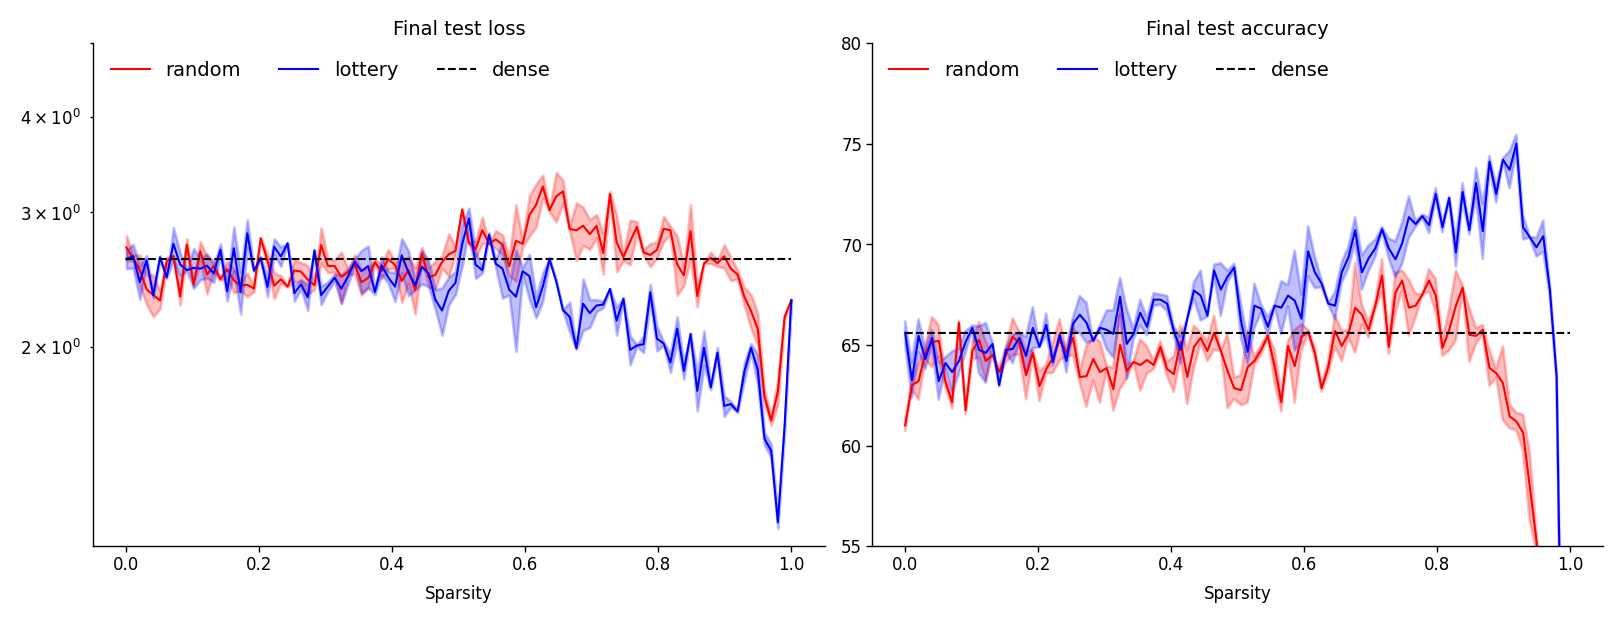

In [32]:
def average_over(trials, trial_name, key):
  ys = [trials[trial_name][i][key] for i in range(len(trials[trial_name]))]
  return np.stack(ys).mean(0), np.stack(ys).std(0) / np.sqrt(len(ys))

x = sparsity_schedule
rand_color, lott_color = 'r', 'b'
fig = plt.figure(figsize=[8,3], dpi=200)

plt.subplot(1,2,1)
y, y_err = average_over(trials, 'rand_stats', 'test_losses')
y, y_err = y[:,-1], y_err[:,-1]
plt.plot(x, y, '-', color=rand_color, label='random') ; plt.fill_between(x, y-y_err, y+y_err, color=rand_color, alpha=0.25)
y, y_err = average_over(trials, 'lott_stats', 'test_losses')
y, y_err = y[:,-1], y_err[:,-1]
plt.plot(x, y, '-', color=lott_color, label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color=lott_color, alpha=0.25)
plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.xlabel('Sparsity') ; plt.title('Final test loss')
plt.yscale('log')
plt.ylim(None, 5e0)
plt.legend(fontsize=7, ncol=3, loc='upper left')

plt.subplot(1,2,2)
y, y_err = average_over(trials, 'rand_stats', 'test_accs')
y, y_err = y[:,-1], y_err[:,-1]
plt.plot(x, y, '-', color=rand_color, label='random') ; plt.fill_between(x, y-y_err, y+y_err, color=rand_color, alpha=0.25)
y, y_err = average_over(trials, 'lott_stats', 'test_accs')
y, y_err = y[:,-1], y_err[:,-1]
plt.plot(x, y, '-', color=lott_color, label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color=lott_color, alpha=0.25)
plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.xlabel('Sparsity') ; plt.title('Final test accuracy')
plt.ylim(55, 80) #plt.ylim(70, 85)
plt.legend(fontsize=7, ncol=3, loc='upper left')

# plt.subplot(1,3,3)
# y, y_err = average_over(trials, 'rand_stats', 'test_accs')
# y, y_err = y.max(-1), y_err[range(y.shape[0]),y.argmax(-1)]
# plt.plot(x, y, '-', color=rand_color, label='random') ; plt.fill_between(x, y-y_err, y+y_err, color=rand_color, alpha=0.25)
# y, y_err = average_over(trials, 'lott_stats', 'test_accs')
# y, y_err = y.max(-1), y_err[range(y.shape[0]),y.argmax(-1)]
# plt.plot(x, y, '-', color=lott_color, label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color=lott_color, alpha=0.25)
# plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
# plt.xlabel('Sparsity') ; plt.title('Max test accuracy')
# plt.ylim(55, 80) #plt.ylim(55, 75)
# plt.legend(fontsize=7, ncol=3, loc='upper left')

plt.show()

os.makedirs(project_dir + 'figures/', exist_ok=True)
fig.savefig(project_dir + 'figures/lottery.png')
fig.savefig(project_dir + 'figures/lottery.pdf')

## Qualitative analysis of masks
What do the masks look like? Looking at the first layer in particular is interesting because we'd like to see whether the lottery ticket has learned any biases towards local connectivity, which would indicate a spatial prior.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


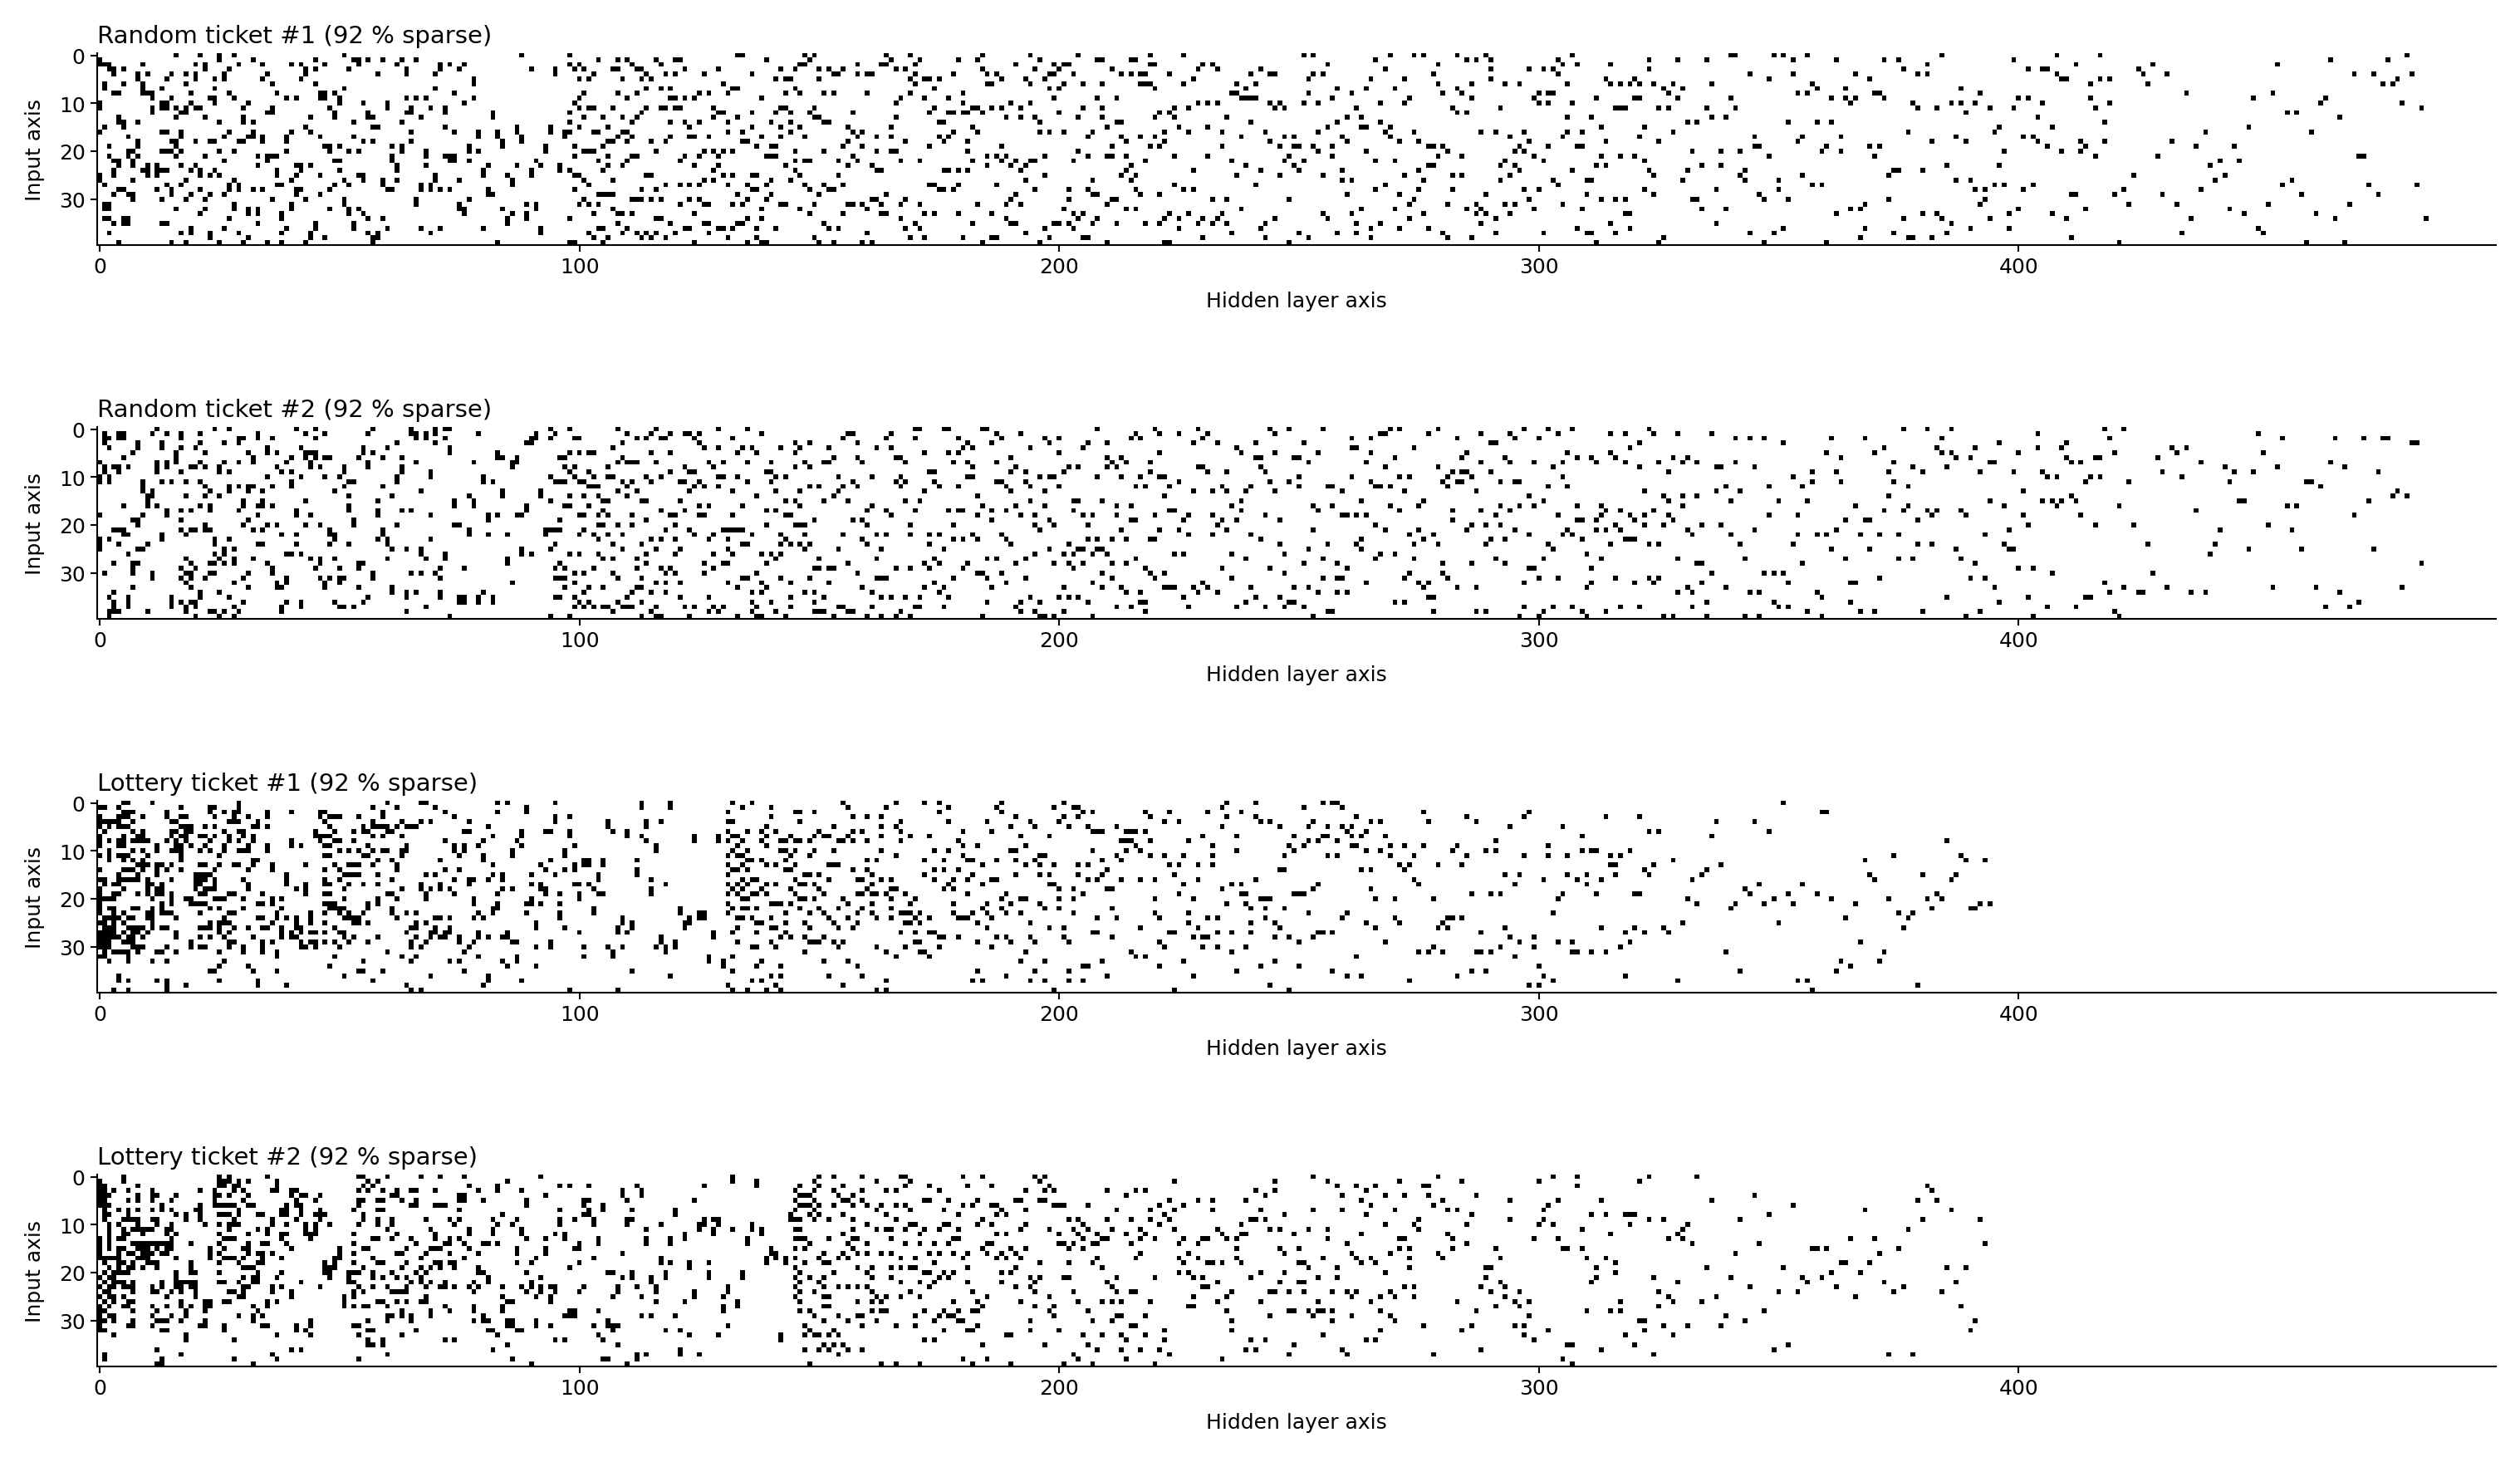

In [33]:
# Get the masks for the weights of the first layer weights
retrain_step = 90
lott_model = trials['lott_models'][0][retrain_step]
lott_mask1 = (lott_model.linear1.linear.weight == 0).cpu().detach().numpy().T
lott_model = trials['lott_models'][1][retrain_step]
lott_mask2 = (lott_model.linear1.linear.weight == 0).cpu().detach().numpy().T

retrain_step = 91
rand_model = trials['rand_models'][0][retrain_step]
rand_mask1 = (rand_model.linear1.linear.weight == 0).cpu().detach().numpy().T
rand_model = trials['rand_models'][1][retrain_step]
rand_mask2 = (rand_model.linear1.linear.weight == 0).cpu().detach().numpy().T

# Sort masks along hidden layer axis
def sort_by_adjacency(mask):
  mask = 1. * mask
  def score_fn(m):
    adjacency = np.sum(m[:-1]*m[1:])
    first_nonzero = np.where(m==1)[0][0] if np.sum(m) > 0 else 41
    num_nonzero = np.sum(m)
    center_of_mass = np.mean(np.where(m==1)[0])
    return adjacency + 0.001 * num_nonzero #- 0.001 * center_of_mass # + 0.001 * num_nonzero #- 0.001 * first_nonzero
  scores = [-score_fn(1-mask[:,i]) for i in range(mask.shape[1])]
  sorted_ixs = np.argsort(scores)
  return mask[:,sorted_ixs].copy()

sort_fn = sort_by_adjacency

# Plot masks
fig = plt.figure(figsize=[10,6], dpi=300)
plt.subplot(4,1,1)
plt.imshow(sort_fn(rand_mask1), cmap='gray')
plt.title('Random ticket #1 ({:.0f} % sparse)'.format(rand_mask1.sum()/(40*5)), loc='left')
plt.xlabel('Hidden layer axis') ; plt.ylabel("Input axis")
plt.subplot(4,1,2)
plt.imshow(sort_fn(rand_mask2), cmap='gray')
plt.title('Random ticket #2 ({:.0f} % sparse)'.format(rand_mask2.sum()/(40*5)), loc='left')
plt.xlabel('Hidden layer axis') ; plt.ylabel("Input axis")
plt.subplot(4,1,3)
plt.imshow(sort_fn(lott_mask1), cmap='gray')
plt.title('Lottery ticket #1 ({:.0f} % sparse)'.format(lott_mask1.sum()/(40*5)), loc='left')
plt.xlabel('Hidden layer axis') ; plt.ylabel("Input axis")
plt.subplot(4,1,4)
plt.imshow(sort_fn(lott_mask2), cmap='gray')
plt.title('Lottery ticket #2 ({:.0f} % sparse)'.format(lott_mask2.sum()/(40*5)), loc='left')
plt.xlabel('Hidden layer axis') ; plt.ylabel("Input axis")

plt.show()
fig.savefig(project_dir + "figures/lottery_mask_vis.png")
fig.savefig(project_dir + "figures/lottery_mask_vis.pdf")

## Let's make a new dataset (from the same distribution) to see how the ticket transfers
Nuance: in order to properly evaluate a lottery ticket, we need to train it on a new dataset from the same distribution, and evaluate it on a new test set from the same distribution. This isn't done in other papers because it's hard to duplicate, eg CIFAR-10. But we can do it here.


In [34]:
args = get_dataset_args()
args.seed = args.seed + 1  # new manual seed -> new dataset from same dataset
data = get_dataset(args=args, download=False, regenerate=True)

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each input: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each input: 40
Number of classes: 10


In [35]:
retrain_step = 91

model_args = get_model_args()
model_args.hidden_size = 500
model_args.eval_every = 100
model_args.learning_rate = 2e-2
model_args.device = DEVICE
model_args.total_steps = 6000
model_args.print_every = 1000
model_args.batch_size = 500 # higher batch size since we want to show overfitting

results = {'dense': [], 'lott': [], 'rand': []}
for t in range(len(trials['rand_stats'])):
  print("\n############  Trial {}  ############".format(t))
  set_seed(model_args.seed + t)
  dense_model = SparseMLP(model_args.input_size, model_args.output_size, \
                          hidden_size=model_args.hidden_size).to(DEVICE)
  _rand_model = copy.deepcopy(trials['rand_models'][t][retrain_step])
  _lott_model = copy.deepcopy(trials['lott_models'][t][retrain_step])

  rand_model = copy.deepcopy(dense_model)
  rand_model.set_layer_masks(_rand_model.get_layer_masks())

  lott_model = copy.deepcopy(dense_model)
  lott_model.set_layer_masks(_lott_model.get_layer_masks())

  dense = train_model(data, dense_model, model_args) ; results['dense'].append(dense)
  lott = train_model(data, lott_model, model_args)   ; results['lott'].append(lott)
  rand = train_model(data, rand_model, model_args)   ; results['rand'].append(rand)


############  Trial 0  ############
step 1000, dt 2.13s, train_loss 1.240e-03, test_loss 2.061e+00, train_acc 100.0, test_acc 64.2
step 2000, dt 2.11s, train_loss 3.471e-04, test_loss 2.366e+00, train_acc 100.0, test_acc 63.9
step 3000, dt 2.11s, train_loss 1.445e-04, test_loss 2.573e+00, train_acc 100.0, test_acc 64.1
step 4000, dt 2.30s, train_loss 6.962e-05, test_loss 2.752e+00, train_acc 100.0, test_acc 64.2
step 5000, dt 2.59s, train_loss 3.619e-05, test_loss 2.913e+00, train_acc 100.0, test_acc 64.4
step 6000, dt 2.45s, train_loss 1.959e-05, test_loss 3.065e+00, train_acc 100.0, test_acc 64.2
step 1000, dt 2.49s, train_loss 4.270e-03, test_loss 2.168e+00, train_acc 100.0, test_acc 65.2
step 2000, dt 2.10s, train_loss 7.413e-04, test_loss 2.697e+00, train_acc 100.0, test_acc 66.0
step 3000, dt 2.10s, train_loss 2.565e-04, test_loss 3.024e+00, train_acc 100.0, test_acc 65.7
step 4000, dt 2.56s, train_loss 1.127e-04, test_loss 3.285e+00, train_acc 100.0, test_acc 65.3
step 5000, dt

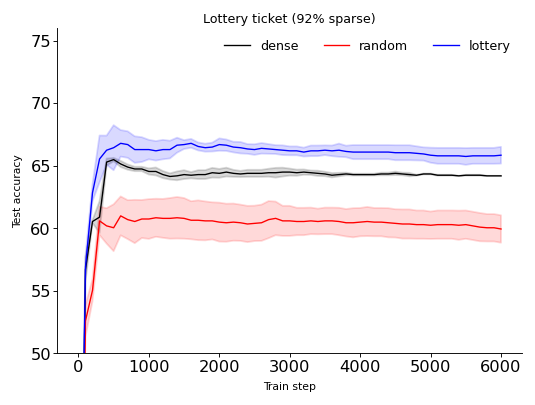

In [36]:
def average_over_results(results, name):
  ys = [results[name][t]['test_acc'] for t in range(len(results[name]))]
  return np.stack(ys).mean(0), np.stack(ys).std(0) / np.sqrt(len(ys))

fig = plt.figure(figsize=(4, 3), dpi=130)
plt.subplot(1,1,1)
x = range(0, model_args.total_steps+1, model_args.eval_every)

y, y_err = average_over_results(results, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)

plt.title('Lottery ticket ({:.0f}% sparse)'.format(100*sparsity_schedule[retrain_step]))
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=7, ncol=3)
plt.ylim(50,76)

plt.show()
fig.savefig(project_dir + 'figures/lottery_asymptotes.png')

## Remove spatial priors and see how lottery ticket fares
First, we do this by shuffling the entire sequence.

In [37]:
data_shuff = {}
np.random.seed(0)
shuffle_ixs = np.random.permutation(40) #np.array(range(32)) #
for k in data.keys():
  if k in ['x', 'x_test', 'steps']:
    data_shuff[k] = data[k][...,shuffle_ixs].copy() # shuffle sequence
  else:
    data_shuff[k] = data[k].copy()

In [38]:
results_shuff = {'dense': [], 'lott': [], 'rand': []}
for t in range(len(trials['rand_stats'])):
  print("\n############  Trial {}  ############".format(t))
  set_seed(model_args.seed + t)
  dense_model = SparseMLP(model_args.input_size, model_args.output_size, \
                          hidden_size=model_args.hidden_size).to(DEVICE)
  _rand_model = copy.deepcopy(trials['rand_models'][t][retrain_step])
  _lott_model = copy.deepcopy(trials['lott_models'][t][retrain_step])

  rand_model = copy.deepcopy(dense_model)
  rand_model.set_layer_masks(_rand_model.get_layer_masks())

  lott_model = copy.deepcopy(dense_model)
  lott_model.set_layer_masks(_lott_model.get_layer_masks())

  dense = train_model(data_shuff, dense_model, model_args) ; results_shuff['dense'].append(dense)
  lott = train_model(data_shuff, lott_model, model_args)   ; results_shuff['lott'].append(lott)
  rand = train_model(data_shuff, rand_model, model_args)   ; results_shuff['rand'].append(rand)


############  Trial 0  ############
step 1000, dt 2.38s, train_loss 1.026e-03, test_loss 2.220e+00, train_acc 100.0, test_acc 62.0
step 2000, dt 4.73s, train_loss 2.889e-04, test_loss 2.539e+00, train_acc 100.0, test_acc 62.5
step 3000, dt 3.96s, train_loss 1.204e-04, test_loss 2.755e+00, train_acc 100.0, test_acc 62.8
step 4000, dt 2.64s, train_loss 5.798e-05, test_loss 2.935e+00, train_acc 100.0, test_acc 63.1
step 5000, dt 2.13s, train_loss 3.012e-05, test_loss 3.100e+00, train_acc 100.0, test_acc 62.9
step 6000, dt 2.09s, train_loss 1.635e-05, test_loss 3.258e+00, train_acc 100.0, test_acc 63.1
step 1000, dt 4.69s, train_loss 6.246e-03, test_loss 2.304e+00, train_acc 100.0, test_acc 63.9
step 2000, dt 3.86s, train_loss 1.050e-03, test_loss 2.967e+00, train_acc 100.0, test_acc 64.3
step 3000, dt 2.36s, train_loss 3.544e-04, test_loss 3.381e+00, train_acc 100.0, test_acc 63.5
step 4000, dt 2.44s, train_loss 1.532e-04, test_loss 3.698e+00, train_acc 100.0, test_acc 63.0
step 5000, dt

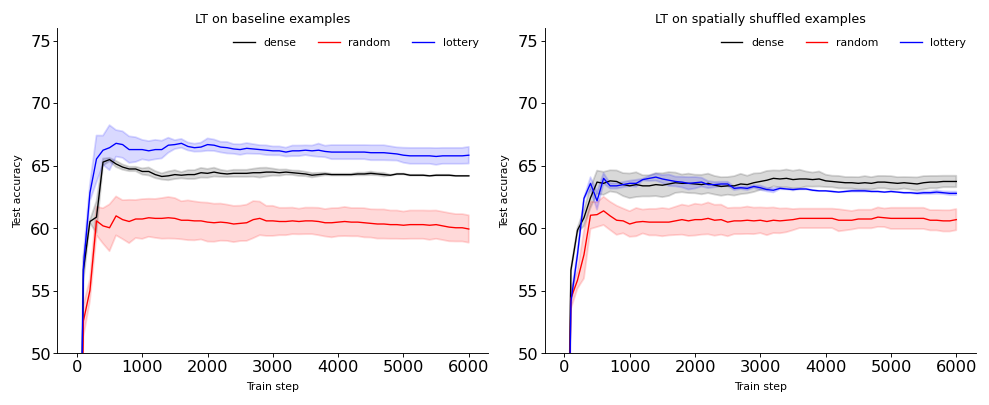

In [39]:
fig = plt.figure(figsize=(7.5, 3), dpi=130)
x = range(0, model_args.total_steps+1, model_args.eval_every)

plt.subplot(1,2,1)
plt.title('LT on baseline examples')
y, y_err = average_over_results(results, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=3)

plt.subplot(1,2,2)
plt.title('LT on spatially shuffled examples')
y, y_err = average_over_results(results_shuff, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results_shuff, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results_shuff, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=3)


plt.show()
fig.savefig(project_dir + 'figures/lottery_asymptotes_shuffled.png')

## Looks like the lottery ticket has some spatial priors, but we need to run more tests to be sure:
There may be a correlation between the spatial priors of the data and how important particular input indices are. If that is the case, then the lottery ticket procedure may have disproportionately pruned weights corresponding to inputs that didn't contribute much to classification. If this is the case, then the "spatial priors" of the lottery ticket are not particularly significant and won't transfer well to other datasets.

But maybe the lottery ticket does have some spatial priors that will transfer well. In order to test whether that is the case, we can simply flip the non-shuffled dataset upside down. This will break the correlation between particular indices that matter more than others while still leaving spatial priors intact in the data. Think about it this way: a CNN will still do well if you flip all your images upside down. So our model's performance on flipped data is a good hint at how well its spatial priors will transfer. If this doesn't hurt performance much, then the lottery ticket represents some sort of reasonably good spatial prior.

In [40]:
data['x_test'][0]

array([ 0.79027827,  0.81387517,  0.96495485,  0.72122595, -0.03240748,
       -0.28947403,  0.38705837,  0.73723783,  0.38279205, -0.16746251,
       -0.21399577,  0.025955  ,  0.00291882,  0.28282577, -1.25675551,
       -2.06009933, -1.71629861, -0.30305327,  0.02960669, -1.49053473,
       -2.16724905, -1.83906903, -0.26118889,  0.36413035, -0.17891161,
       -0.27629091, -0.13228634,  0.01394688, -0.47465012, -0.57515785,
       -0.37445353,  0.05180054,  0.32990678,  0.05195449, -0.91084646,
       -0.94110542, -0.34693864, -0.3011403 , -0.95394325, -1.39942009])

In [41]:
data_flip = {}
for k in data.keys():
  if k in ['x', 'x_test', 'steps']:
    data_flip[k] = data[k][...,::-1].copy() # flip sequence upside-down
  else:
    data_flip[k] = data[k].copy()

In [42]:
data_flip['x_test'][0]

array([-1.39942009, -0.95394325, -0.3011403 , -0.34693864, -0.94110542,
       -0.91084646,  0.05195449,  0.32990678,  0.05180054, -0.37445353,
       -0.57515785, -0.47465012,  0.01394688, -0.13228634, -0.27629091,
       -0.17891161,  0.36413035, -0.26118889, -1.83906903, -2.16724905,
       -1.49053473,  0.02960669, -0.30305327, -1.71629861, -2.06009933,
       -1.25675551,  0.28282577,  0.00291882,  0.025955  , -0.21399577,
       -0.16746251,  0.38279205,  0.73723783,  0.38705837, -0.28947403,
       -0.03240748,  0.72122595,  0.96495485,  0.81387517,  0.79027827])

In [43]:
results_flip = {'dense': [], 'lott': [], 'rand': []}
for t in range(len(trials['rand_stats'])):
  print("\n############  Trial {}  ############".format(t))
  set_seed(model_args.seed + t)
  dense_model = SparseMLP(model_args.input_size, model_args.output_size, \
                          hidden_size=model_args.hidden_size).to(DEVICE)
  _rand_model = copy.deepcopy(trials['rand_models'][t][retrain_step])
  _lott_model = copy.deepcopy(trials['lott_models'][t][retrain_step])

  rand_model = copy.deepcopy(dense_model)
  rand_model.set_layer_masks(_rand_model.get_layer_masks())

  lott_model = copy.deepcopy(dense_model)
  lott_model.set_layer_masks(_lott_model.get_layer_masks())

  dense = train_model(data_flip, dense_model, model_args) ; results_flip['dense'].append(dense)
  lott = train_model(data_flip, lott_model, model_args)   ; results_flip['lott'].append(lott)
  rand = train_model(data_flip, rand_model, model_args)   ; results_flip['rand'].append(rand)


############  Trial 0  ############
step 1000, dt 2.12s, train_loss 2.058e-03, test_loss 1.848e+00, train_acc 100.0, test_acc 63.8
step 2000, dt 2.12s, train_loss 5.547e-04, test_loss 2.112e+00, train_acc 100.0, test_acc 63.6
step 3000, dt 2.12s, train_loss 2.285e-04, test_loss 2.296e+00, train_acc 100.0, test_acc 63.1
step 4000, dt 2.09s, train_loss 1.108e-04, test_loss 2.446e+00, train_acc 100.0, test_acc 63.0
step 5000, dt 2.28s, train_loss 5.790e-05, test_loss 2.581e+00, train_acc 100.0, test_acc 63.0
step 6000, dt 2.69s, train_loss 3.170e-05, test_loss 2.708e+00, train_acc 100.0, test_acc 63.0
step 1000, dt 2.12s, train_loss 4.957e-03, test_loss 2.464e+00, train_acc 100.0, test_acc 62.3
step 2000, dt 2.49s, train_loss 8.296e-04, test_loss 3.146e+00, train_acc 100.0, test_acc 62.1
step 3000, dt 2.90s, train_loss 2.855e-04, test_loss 3.552e+00, train_acc 100.0, test_acc 62.2
step 4000, dt 2.11s, train_loss 1.243e-04, test_loss 3.868e+00, train_acc 100.0, test_acc 62.3
step 5000, dt

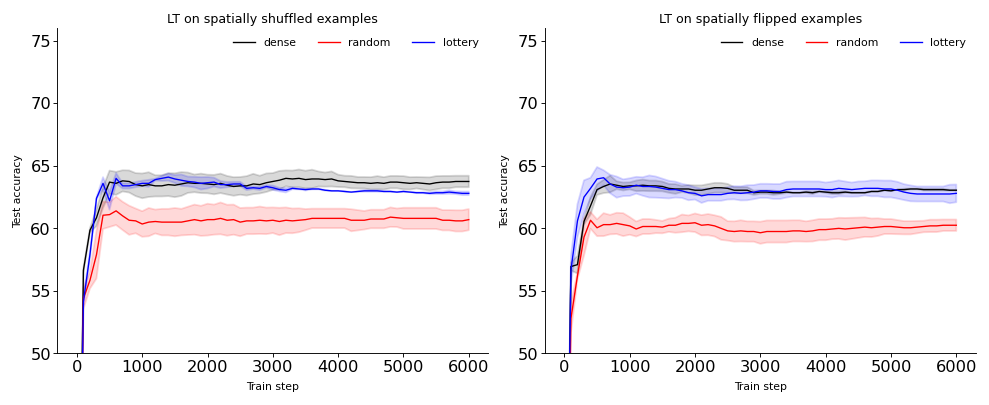

In [44]:
fig = plt.figure(figsize=(7.5, 3), dpi=130)
x = range(0, model_args.total_steps+1, model_args.eval_every)

plt.subplot(1,2,1)
plt.title('LT on spatially shuffled examples')
y, y_err = average_over_results(results_shuff, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results_shuff, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results_shuff, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=3)

plt.subplot(1,2,2)
plt.title('LT on spatially flipped examples')
y, y_err = average_over_results(results_flip, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results_flip, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results_flip, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=3)


plt.show()
fig.savefig(project_dir + 'figures/lottery_asymptotes_flipped.png')

## This has become a monster notebook.
Instead of responsibly dividing it into two notebooks, let's save a checkpoint and continue on. Now we can start from here without having to recompute everything from scratch.

In [45]:
things = [trials, model_args, retrain_step, results, results_shuff, results_flip]
to_pickle(things, path=project_dir + 'lottery_analysis.pkl')

In [46]:
things = from_pickle(path=project_dir + 'lottery_analysis.pkl')
[trials, model_args, retrain_step, results, results_shuff, results_flip] = things

## Our lottery ticket generalizes surprisingly well to a flipped version of the dataset. What happens if we shuffle _chunks_ of the sequence
If the lottery ticket has learned good spatial priors, then we would expect its performance to decrease only partially when we shuffle chunks of the sequence, since some of the spatial information is still available.

In [47]:
data_chunks = {}
for k in data.keys():
  if k in ['x', 'x_test', 't']:
    data_chunks[k] = np.concatenate([data[k][...,20:30],
                                     data[k][...,30:40],
                                     data[k][...,:10],
                                     data[k][...,10:20]],
                                     axis=-1).copy() # exhange first and second halves
  else:
    data_chunks[k] = data[k].copy()

In [48]:
results_chunks = {'dense': [], 'lott': [], 'rand': []}
for t in range(len(trials['rand_stats'])):
  print("\n############  Trial {}  ############".format(t))
  set_seed(model_args.seed + t)
  dense_model = SparseMLP(model_args.input_size, model_args.output_size, \
                          hidden_size=model_args.hidden_size).to(DEVICE)
  _rand_model = copy.deepcopy(trials['rand_models'][t][retrain_step])
  _lott_model = copy.deepcopy(trials['lott_models'][t][retrain_step])

  rand_model = copy.deepcopy(dense_model)
  rand_model.set_layer_masks(_rand_model.get_layer_masks())

  lott_model = copy.deepcopy(dense_model)
  lott_model.set_layer_masks(_lott_model.get_layer_masks())

  dense = train_model(data_chunks, dense_model, model_args) ; results_chunks['dense'].append(dense)
  lott = train_model(data_chunks, lott_model, model_args)   ; results_chunks['lott'].append(lott)
  rand = train_model(data_chunks, rand_model, model_args)   ; results_chunks['rand'].append(rand)


############  Trial 0  ############
step 1000, dt 2.11s, train_loss 7.306e-04, test_loss 1.987e+00, train_acc 100.0, test_acc 65.8
step 2000, dt 3.06s, train_loss 1.904e-04, test_loss 2.261e+00, train_acc 100.0, test_acc 65.6
step 3000, dt 6.64s, train_loss 7.772e-05, test_loss 2.442e+00, train_acc 100.0, test_acc 65.3
step 4000, dt 3.71s, train_loss 3.719e-05, test_loss 2.596e+00, train_acc 100.0, test_acc 65.3
step 5000, dt 2.28s, train_loss 1.899e-05, test_loss 2.733e+00, train_acc 100.0, test_acc 65.4
step 6000, dt 2.50s, train_loss 1.017e-05, test_loss 2.859e+00, train_acc 100.0, test_acc 65.3
step 1000, dt 2.51s, train_loss 6.653e-03, test_loss 2.594e+00, train_acc 100.0, test_acc 60.8
step 2000, dt 2.19s, train_loss 1.126e-03, test_loss 3.315e+00, train_acc 100.0, test_acc 60.9
step 3000, dt 2.89s, train_loss 3.901e-04, test_loss 3.751e+00, train_acc 100.0, test_acc 61.4
step 4000, dt 4.32s, train_loss 1.694e-04, test_loss 4.089e+00, train_acc 100.0, test_acc 61.4
step 5000, dt

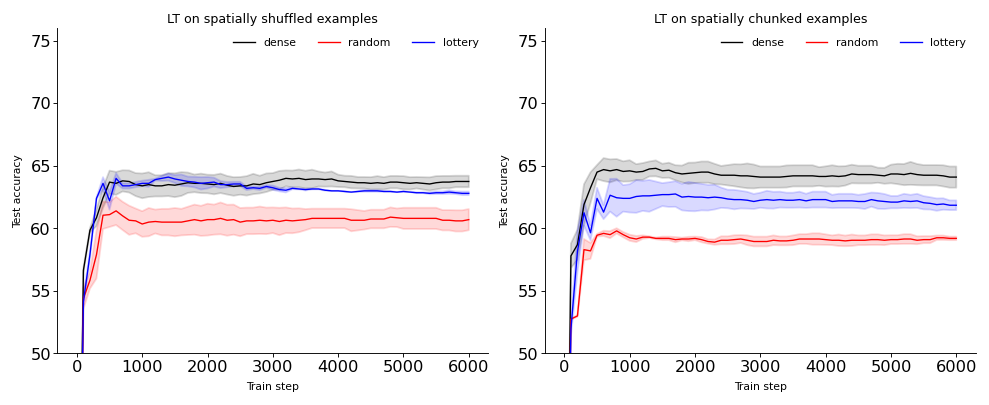

In [49]:
fig = plt.figure(figsize=(7.5, 3), dpi=130)
x = range(0, model_args.total_steps+1, model_args.eval_every)

plt.subplot(1,2,1)
plt.title('LT on spatially shuffled examples')
y, y_err = average_over_results(results_shuff, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results_shuff, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results_shuff, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=3)

plt.subplot(1,2,2)
plt.title('LT on spatially chunked examples')
y, y_err = average_over_results(results_chunks, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results_chunks, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results_chunks, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=3)


plt.show()
fig.savefig(project_dir + 'figures/lottery_asymptotes_chunks.png')

## Rebuild models

In [50]:
set_seed(model_args.seed)
dense_model = SparseMLP(model_args.input_size, model_args.output_size,\
                        hidden_size=model_args.hidden_size).to(DEVICE)
_rand_model = copy.deepcopy(trials['rand_models'][0][retrain_step])
_lott_model = copy.deepcopy(trials['lott_models'][0][retrain_step])

rand_model = copy.deepcopy(dense_model)
rand_model.set_layer_masks(_rand_model.get_layer_masks())

lott_model = copy.deepcopy(dense_model)
lott_model.set_layer_masks(_lott_model.get_layer_masks())

## Looks like our lottery ticket has some decent spatial priors
One thing this implies is that the lottery ticket may have more local connectivity
## We can test for this by measuring the probability of nonzero parameters being adjacent to one another
This will tell us whether local connections are more frequent in lottery tickets compared to random tickets. Let's do this.

### 1. Get masks indicating nonzero weights of first fully-connected layer


In [51]:
rand_model = copy.deepcopy(dense_model)
rand_model.set_layer_masks(_rand_model.get_layer_masks())

lott_model = copy.deepcopy(dense_model)
lott_model.set_layer_masks(_lott_model.get_layer_masks())

w1_rand = rand_model.linear1.linear.weight.cpu().detach().numpy()
w1_lott = lott_model.linear1.linear.weight.cpu().detach().numpy()

w1_rand_nonzero = (w1_rand!=0).astype(np.float32)
w1_lott_nonzero = (w1_lott!=0).astype(np.float32)

### 2. Count the number of times that nonzero parameters are adjacent to one another

In [52]:
w1_rand_2adjacent, w1_lott_2adjacent = [], []
w1_rand_3adjacent, w1_lott_3adjacent = [], []
w1_rand_4adjacent, w1_lott_4adjacent = [], []
input_dim = w1_rand.shape[1] * 1.
for k in range(w1_rand.shape[0]):
  w1_rand_2adjacent += [np.sum(w1_rand_nonzero[k,:-1] * w1_rand_nonzero[k,1:]) / input_dim]
  w1_lott_2adjacent += [np.sum(w1_lott_nonzero[k,:-1] * w1_lott_nonzero[k,1:]) / input_dim]

  w1_rand_3adjacent += [np.sum(w1_rand_nonzero[k,:-2] * w1_rand_nonzero[k,1:-1] * w1_rand_nonzero[k,2:]) / input_dim]
  w1_lott_3adjacent += [np.sum(w1_lott_nonzero[k,:-2] * w1_lott_nonzero[k,1:-1] * w1_lott_nonzero[k,2:]) / input_dim]

  w1_rand_4adjacent += [np.sum(w1_rand_nonzero[k,:-3] * w1_rand_nonzero[k,1:-2] * \
                               w1_rand_nonzero[k,2:-1] * w1_rand_nonzero[k,3:]) / input_dim]
  w1_lott_4adjacent += [np.sum(w1_lott_nonzero[k,:-3] * w1_lott_nonzero[k,1:-2] * \
                              w1_lott_nonzero[k,2:-1] * w1_rand_nonzero[k,3:]) / input_dim]

### 3. Calculate basic statistics for these adjacencies

In [53]:
ticket_names = ['random', 'lottery']
sqrtN = np.sqrt(len(w1_rand_2adjacent))

p_2adjacent = [np.mean(w1_rand_2adjacent), np.mean(w1_lott_2adjacent)]
p_2adjacent_err = [np.std(w1_rand_2adjacent)/sqrtN, np.std(w1_lott_2adjacent)/sqrtN]

p_3adjacent = [np.mean(w1_rand_3adjacent), np.mean(w1_lott_3adjacent)]
p_3adjacent_err = [np.std(w1_rand_3adjacent)/sqrtN, np.std(w1_lott_3adjacent)/sqrtN]

p_4adjacent = [np.mean(w1_rand_4adjacent), np.mean(w1_lott_4adjacent)]
p_4adjacent_err = [np.std(w1_rand_4adjacent)/sqrtN, np.std(w1_lott_4adjacent)/sqrtN]

### 4. Plot the empirical statistics

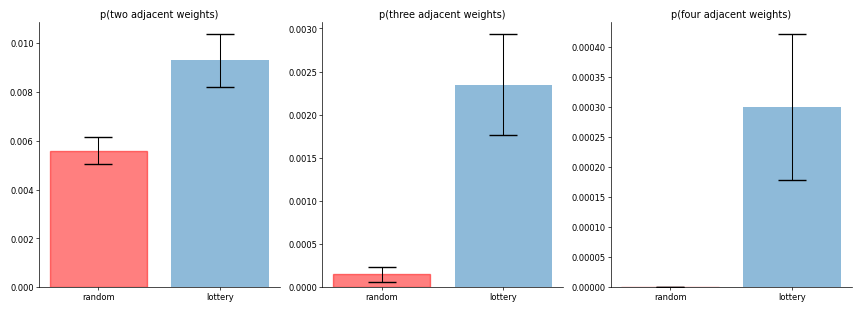

In [54]:
fig = plt.figure(figsize=[8.5,3], dpi=100)

ax = plt.subplot(1,3,1)
x = np.arange(len(ticket_names))
ax.set_xticks(x)
ax.set_xticklabels(ticket_names)
barlist = plt.bar(x, p_2adjacent, yerr=p_2adjacent_err, width=0.8, alpha=0.5, ecolor='black', capsize=10)
barlist[0].set_color('red')
plt.title("p(two adjacent weights)")

ax = plt.subplot(1,3,2)
x = np.arange(len(ticket_names))
ax.set_xticks(x)
ax.set_xticklabels(ticket_names)
barlist = plt.bar(x, p_3adjacent, yerr=p_3adjacent_err, width=0.8, alpha=0.5, ecolor='black', capsize=10)
barlist[0].set_color('red')
plt.title("p(three adjacent weights)")

ax = plt.subplot(1,3,3)
x = np.arange(len(ticket_names))
ax.set_xticks(x)
ax.set_xticklabels(ticket_names)
barlist = plt.bar(x, p_4adjacent, yerr=p_4adjacent_err, width=0.8, alpha=0.5, ecolor='black', capsize=10)
barlist[0].set_color('red')
plt.title("p(four adjacent weights)")

plt.show()
fig.savefig(project_dir + 'figures/lottery_adjacency.png')
fig.savefig(project_dir + 'figures/lottery_adjacency.pdf')

## One more sanity check: keep sparsity pattern but use different initialization
Based on what we're seeing above, the sparsity pattern itself represents some sort of inductive bias for local connectivity. If this is true, then we should be able to start from a different (scratch) initialization and still see a jump in performance. Let's try it.

In [55]:
results_seed = {'dense': [], 'lott': [], 'rand': []}
for t in range(len(trials['rand_stats'])):
  print("\n############  Trial {}  ############".format(t))
  set_seed(model_args.seed + t + 1)
  dense_model = SparseMLP(model_args.input_size, model_args.output_size, \
                          hidden_size=model_args.hidden_size).to(DEVICE)
  _rand_model = copy.deepcopy(trials['rand_models'][t][retrain_step])
  _lott_model = copy.deepcopy(trials['lott_models'][t][retrain_step])

  rand_model = copy.deepcopy(dense_model)
  rand_model.set_layer_masks(_rand_model.get_layer_masks())

  lott_model = copy.deepcopy(dense_model)
  lott_model.set_layer_masks(_lott_model.get_layer_masks())

  dense = train_model(data, dense_model, model_args) ; results_seed['dense'].append(dense)
  lott = train_model(data, lott_model, model_args)   ; results_seed['lott'].append(lott)
  rand = train_model(data, rand_model, model_args)   ; results_seed['rand'].append(rand)


############  Trial 0  ############
step 1000, dt 2.16s, train_loss 1.894e-03, test_loss 1.885e+00, train_acc 100.0, test_acc 63.7
step 2000, dt 2.14s, train_loss 5.030e-04, test_loss 2.173e+00, train_acc 100.0, test_acc 63.7
step 3000, dt 2.11s, train_loss 2.060e-04, test_loss 2.362e+00, train_acc 100.0, test_acc 63.2
step 4000, dt 2.12s, train_loss 9.894e-05, test_loss 2.518e+00, train_acc 100.0, test_acc 63.1
step 5000, dt 2.67s, train_loss 5.124e-05, test_loss 2.658e+00, train_acc 100.0, test_acc 63.0
step 6000, dt 2.30s, train_loss 2.772e-05, test_loss 2.792e+00, train_acc 100.0, test_acc 63.3
step 1000, dt 2.10s, train_loss 3.732e-03, test_loss 2.108e+00, train_acc 100.0, test_acc 64.4
step 2000, dt 2.12s, train_loss 6.494e-04, test_loss 2.648e+00, train_acc 100.0, test_acc 64.1
step 3000, dt 2.15s, train_loss 2.236e-04, test_loss 2.985e+00, train_acc 100.0, test_acc 64.0
step 4000, dt 2.20s, train_loss 9.737e-05, test_loss 3.251e+00, train_acc 100.0, test_acc 63.8
step 5000, dt

<ipython-input-56-fba28d50d039>:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout() ; plt.show()


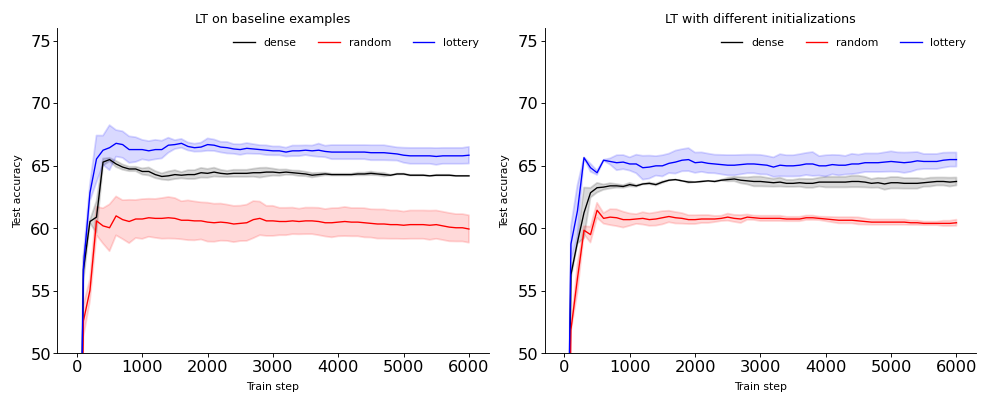

In [56]:
fig = plt.figure(figsize=(7.5, 3), dpi=130)
x = range(0, model_args.total_steps+1, model_args.eval_every)

plt.subplot(1,2,1)
plt.title('LT on baseline examples')
y, y_err = average_over_results(results, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=3)

plt.subplot(1,2,2)
plt.title('LT with different initializations')
y, y_err = average_over_results(results_seed, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results_seed, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results_seed, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=3)

plt.show()
fig.savefig(project_dir + 'figures/lottery_asymptotes_reinit.png')

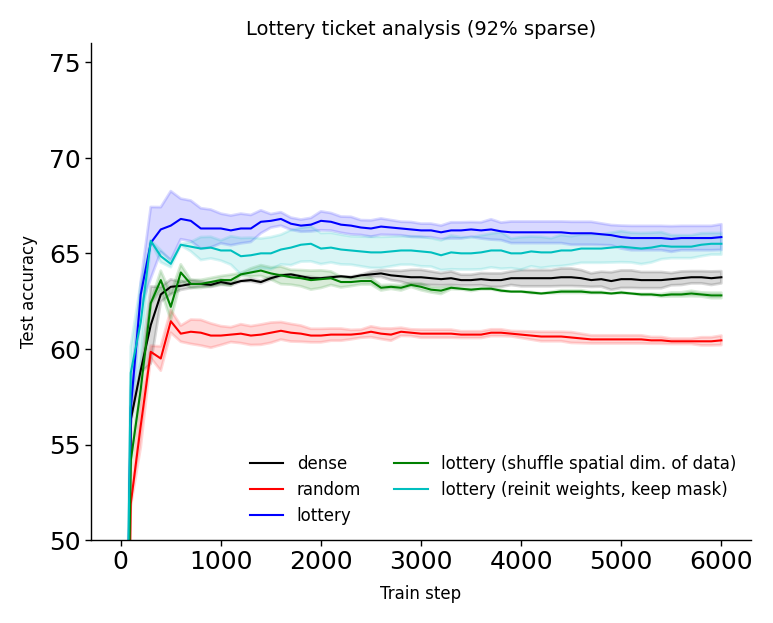

In [57]:
fig = plt.figure(figsize=(7.5/2, 3), dpi=200)
x = range(0, model_args.total_steps+1, model_args.eval_every)

plt.subplot(1,1,1)
plt.title('Lottery ticket analysis ({:.0f}% sparse)'.format(100*sparsity_schedule[retrain_step]))
y, y_err = average_over_results(results_seed, 'dense')
plt.plot(x, y, 'k-', label='dense') ; plt.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.15)
y, y_err = average_over_results(results_seed, 'rand')
plt.plot(x, y, 'r-', label='random') ; plt.fill_between(x, y-y_err, y+y_err, color='r', alpha=0.15)
y, y_err = average_over_results(results, 'lott')
plt.plot(x, y, 'b-', label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color='b', alpha=0.15)
y, y_err = average_over_results(results_shuff, 'lott')
plt.plot(x, y, 'g-', label='lottery (shuffle spatial dim. of data)') ; plt.fill_between(x, y-y_err, y+y_err, color='g', alpha=0.15)
y, y_err = average_over_results(results_seed, 'lott')
plt.plot(x, y, 'c-', label='lottery (reinit weights, keep mask)') ; plt.fill_between(x, y-y_err, y+y_err, color='c', alpha=0.15)
plt.ylim(50,76)
plt.ylabel('Test accuracy') ; plt.xlabel("Train step")
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9) ; plt.legend(fontsize=6, ncol=2, loc='lower right')

plt.show()
fig.savefig(project_dir + 'figures/lottery_summary.png')
fig.savefig(project_dir + 'figures/lottery_summary.pdf')